***Note: this is the CyclicFlowModulation.ipynb notebook. The
PDF version "Cyclic Flow Modulation"
is available [here](CyclicFlowModulation.pdf).***

# Introduction
The reaction 
\ch{F6P + ATP <>[PFK] F16P + ADP}
catalysed by the enzyme PFK is a key step in glycolysis where:

- \ch{PFK} phosphofructokinase 
- \ch{F6P} fructose-6-phosphate
- \ch{F16P} fructose-1,6-biphosphate

As pointed out by 
<cite data-cite="Cor12">Cornish-Bowden (2012)</cite>, section 12.1.1., the PFK-catalysed reaction forms a cycle with the reaction:
\ch{F16P + H2O <>[FBP] F6P + Pi}
where:

- \ch{FBP} fructose biphosphatase
- \ch{Pi} inorganic phosphate

This cycle is *modulated* by a number of species which simultaneously activate the PFK reaction and inhibit the FBP reaction or *vice-versa*.  
<cite data-cite="Cor12">Cornish-Bowden (2012)</cite> [section 12.1.1],
<cite data-cite="GarGri17">Garret and Grisham (2017)</cite> [sections 18.3c,22.1 (3), 22.2a]. Indeed <cite data-cite="GarGri17">Garret and Grisham (2017)</cite> [section 22.2b] explicitly states that "substrate cycles provide metabolic control mechanisms".

The species which activate PFK and inhibit FBP include:

- \ch{AMP}
- \ch{F26P} fructose-2,6-phosphate

The species which inhibit PFK and activate FBP include:

- ATP
- \ch{Cit} citrate

Because of the cyclic nature of these two reactions, and the fact that flow is modulated, the term  **Cyclic Flow Modulation** (CFM) is used to decribe such reaction systems.

- This note gives a bond graph <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> interpretation of such Cyclic Flow Modulation and uses  [BondGraphTools](https://pypi.org/project/BondGraphTools/) <cite data-cite="CudGawPanCra19X">(Cudmore et. al., 2019)</cite> to build an analyse a simple example of Cyclic Flow Modulation.

- The note also provides an example of graphical computational modularity where graphical representions in SVG format are converted using svgBondGraph -- see Tutorial [svgBondGraph](svgBondGraph.ipynb)

- A more detaied discussion is found in <cite data-cite="Gaw20X">(Gawthrop, 2020)</cite>. 

## Import some python code
The bond graph analysis uses a number of Python modules:

In [1]:
## Some useful imports

import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 25})

import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Stoichiometry to BG
import stoichBondGraph as stbg


## Modular bond graphs
import modularBondGraph as mbg

## Control systems package
import control as con


## Data structure copy
import copy

## For reimporting: use imp.reload(module)
import importlib as imp

## Saving and loading data
import pickle

## Set quiet=False for verbose output
quiet = True

## Model can be reinitialised by setting True
## If False, processed models read from file
Initialise_model = True



In /home/peterg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/peterg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/peterg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/peterg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/peterg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def convertBG(name,quiet=True,flatten=True):
    
    svg = name+'.svg'
    
    print('Processing', svg)
    
    ## Convert svg to BGtools and import
    sbg.model(svg,quiet=quiet)
    exec(f'import {name}')
    exec(f'imp.reload({name})')
    if flatten:
        print('    Flattening')
        ## Create stoichiometry
        ss = eval(f'st.stoich({name}.model(),quiet=quiet)')
        
        ## Create flattened BG
        stbg.model(ss,filename=name)
        exec(f'imp.reload({name})')
 
    ## Stoichiometry
    print('    Computing stoichiometry')
        
    s = eval(f'st.stoich({name}.model(),quiet=quiet)')
        
    return s



Sfilename = 'S.dat'
if Initialise_model:
    S = {} ## Stoichiometry of each system
    names = ['ecr','ECR',
             'CFM']
    TopLevel = []
    #TopLevel = ['mCoop','Pfb','PIfb','Pfb0','PIfb0','Pol','PIol','Pol0','PIol0']
    for name in names:
        flatten = not name in TopLevel
        s = convertBG(name+'_abg', flatten=flatten)
        S[name] = s
        
    Sfile = open(Sfilename, 'wb')
    pickle.dump(S, Sfile)
else:
    Sfile = open(Sfilename, 'rb')
    S = pickle.load(Sfile)
    

# Modulated Pumped Enzyme Catalysed Reaction


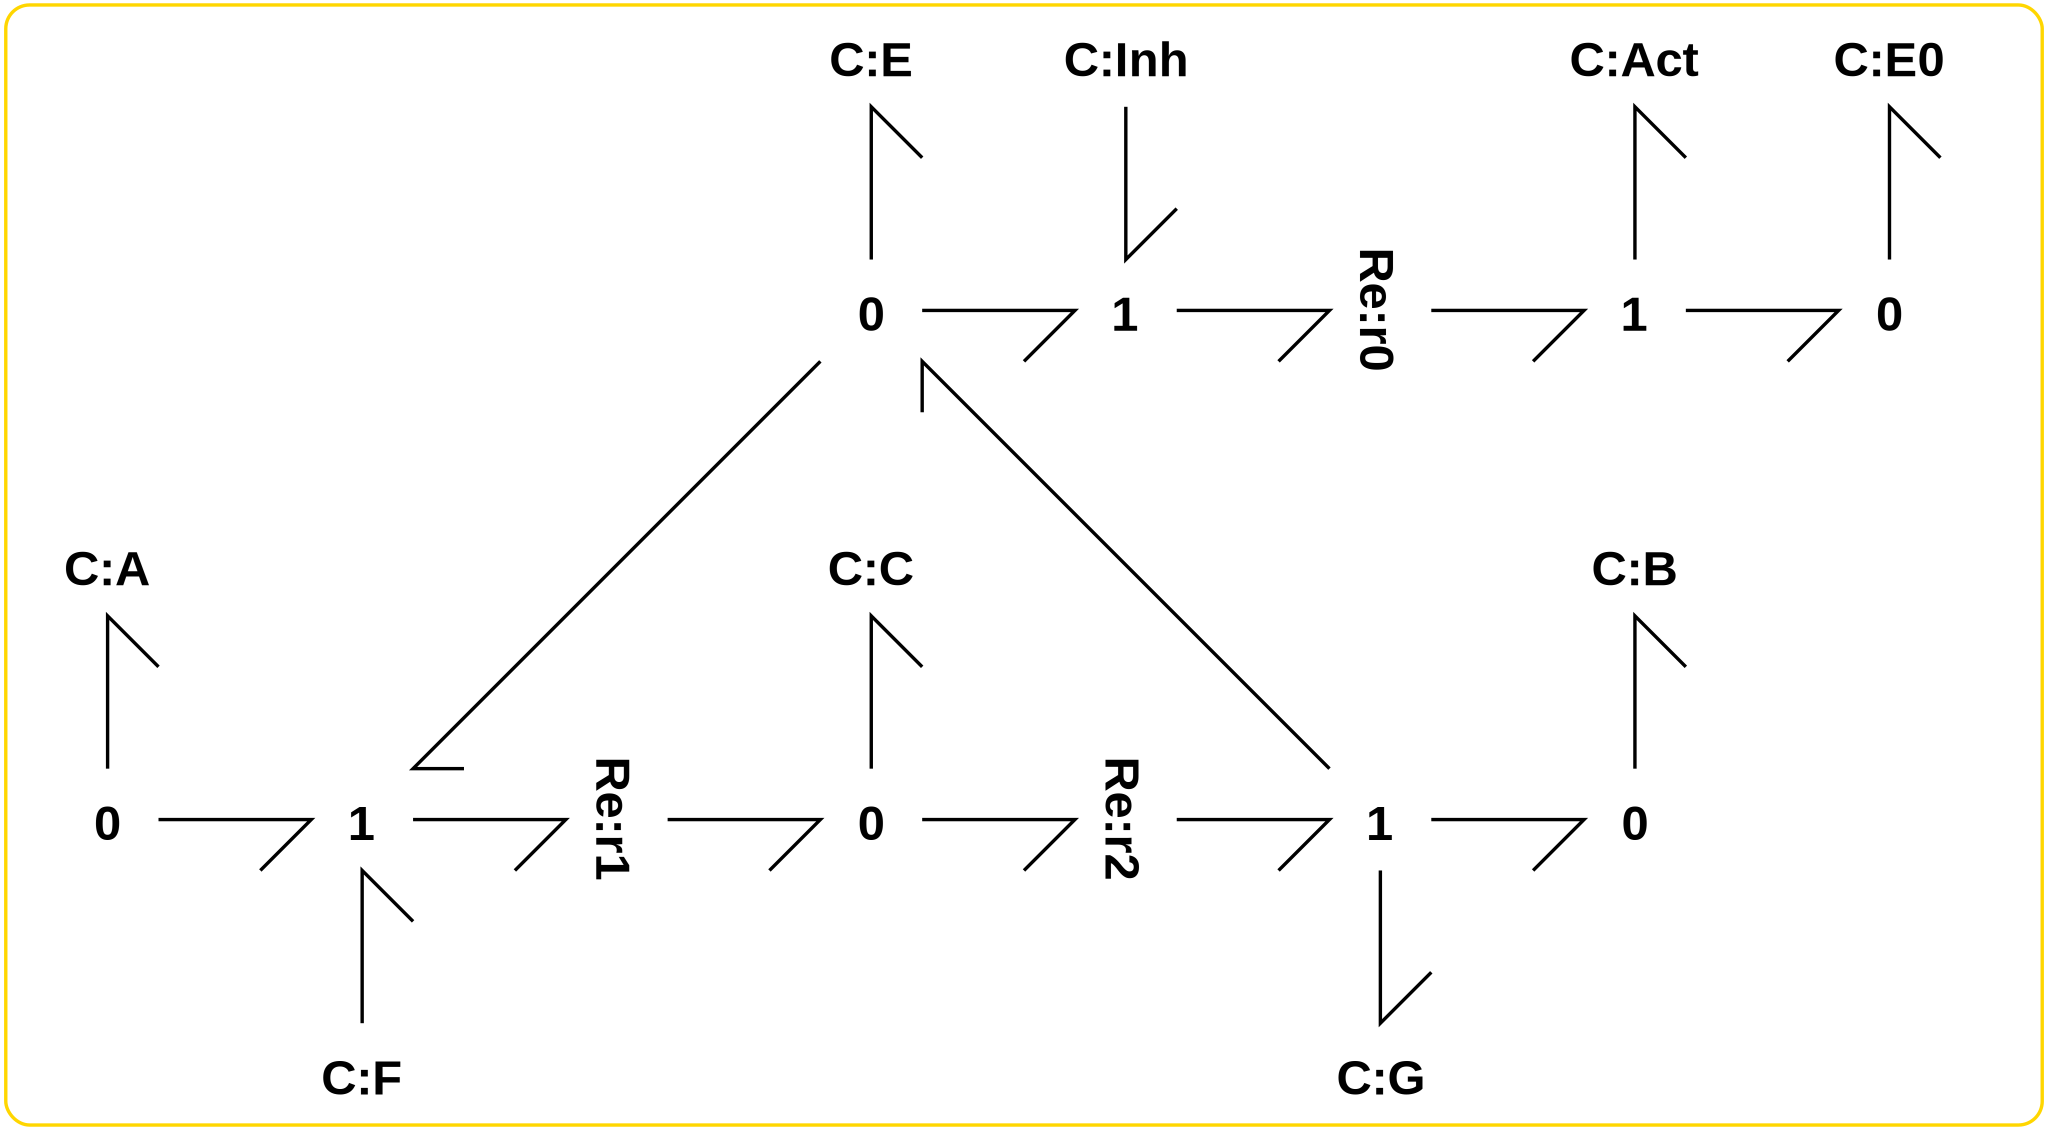

In [3]:
disp.SVG('ecr_abg.svg')

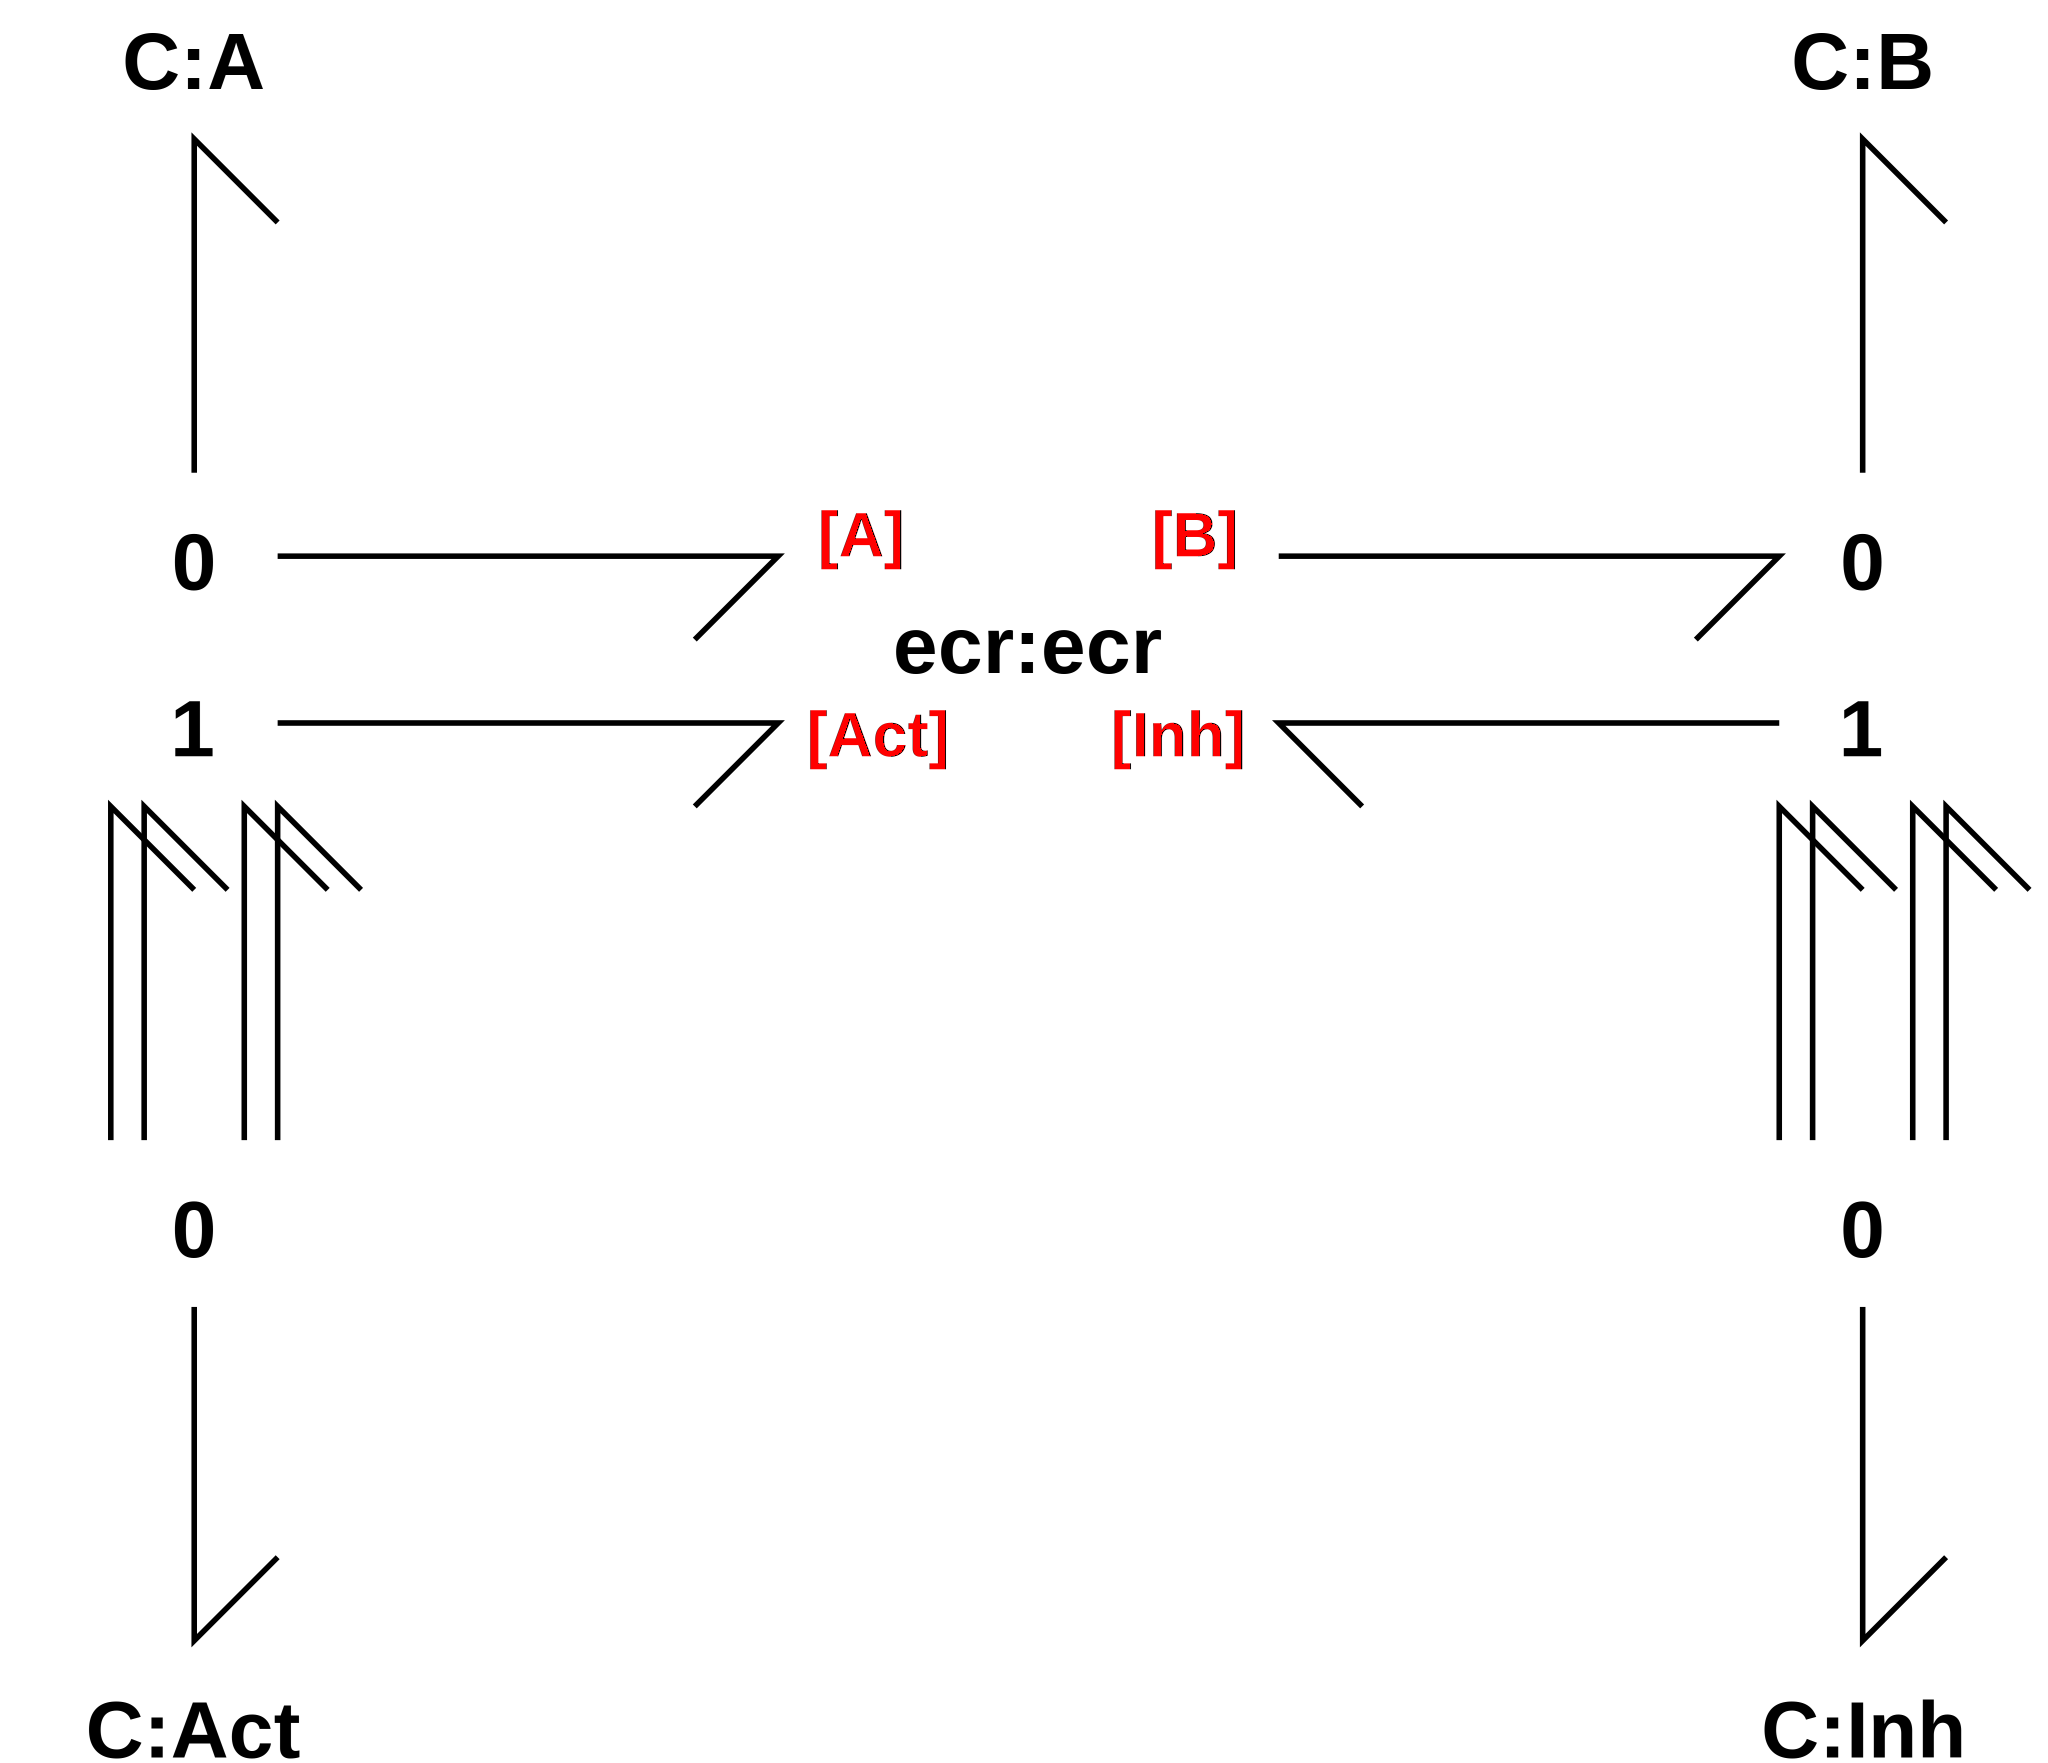

In [4]:
disp.SVG('ECR_abg.svg')

## Steady-state analysis
The system represented by the bond graph is similar to that of Section 5(a) of <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> with the following differences:

- The chemostats F and G pump (or drive) the reaction from A to B; K_F is larger than K_G.
- The amount of enzyme E is modulated by reaction r0 and the activation and inhibition potentials.
- The activation and inhibition is via N=4 bonds corresponding to cooperative binding of N molecules.

The three reactions are:
\begin{align}
\ch{N Inh + E &<>[r0 ] N Act + E0 }\\
\ch{A + E + F &<>[ r1 ] C }\\
\ch{C &<>[ r2 ] B + E + G }
\end{align}

The three substance E0, E and C form a conserved moiety so that $x_{E0}+x_E+x_C=e_0$ where the constant $e_0$ is the total amount.

From  <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>, $x_C$ the amount of C is gven by:
\begin{align}
x_C &= \frac{K_e}{K_c}\sigma_v x_e  \\
 \text{ where }
 \sigma_v 
 &= \frac{\kappa_1 e^{\frac{\Phi^f}{V_N}} + \kappa_2 e^{\frac{\Phi^r}{V_N}}}{\kappa_1  +
   \kappa_2}\\
   \text {and }
   \Phi^f &= K_F K_A x_F x_A \;; \Phi^r = K_G K_B x_G x_B 
\end{align}

Using the equilibrium conditions for reaction R0:
\begin{align}
x_{E0} &= \left (K_{IA} x_{IA} \right )^N x_E\\
\text{where }
x_{IA} &= \frac{x_I}{x_A}\\
\text{and }
K_{IA} &= \frac{K_E K_I}{K_{E0} K_{A}} 
\end{align}

Using the conserved moiety, it follows that:
\begin{align}
x_E &= \frac{e_0}{1 + \frac{K_e}{K_c}\sigma_v + \left (K_{IA} x_{IA} \right )^N}
\end{align}

Following the analysis of <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>, the stready state reaction flow $v$  associiated with r1 and r2 is:
\begin{align} 
 v &= \bar{\kappa} \frac{K_e e_0}{1 + \frac{K_e}{K_c} \sigma_v + \left(K_{IA} x_{IA}\right)^N}
 \Phi \\
 \text{where }
 \Phi &= \Phi_f - \Phi_r \text{ and } \bar{\kappa} = \frac{\kappa_1 \kappa_2}{{\kappa_1+\kappa_2}}
\end{align}

The *incremental gain* $\dfrac{dv}{dx_{IA}}$ is:
\begin{align} 
 \frac{dv}{dx_{IA}} &= -N K_{IA}^N x_{IA}^{N-1}
 \bar{\kappa} \frac{K_e e_0}{\left (1 + \frac{K_e}{K_c} \sigma_v + \left(K_{IA} x_{IA}\right)^N\right)^2}
\end{align}

Noting that $\phi = \phi^\circ + V_N \ln \frac{x}{x^\circ}$ and so $\frac{d\phi}{dx}=\frac{V_N}{x}$, it follows that:
\begin{align} 
 \frac{dv}{d\phi_{IA}} &= -N \left(K_{IA} x_{IA}\right)^{N}
 \bar{\kappa} \frac{K_e e_0}{V_N\left (1 + \frac{K_e}{K_c} \sigma_v + \left(K_{IA} x_{IA}\right)^N\right)^2}
\end{align}

This can be reexpressed in terms of $\phi_{AI}$ and $x_{IA}$ by noting that 
$\left(K_{IA} x_{IA}\right)^N = \left(K_{AI} x_{AI}\right)^{-N}$.

In [5]:
## Theoretical steady-state flow in modulated enzyme-catalysed reaction
def mECR_flow(x_A,x_B,x_IA,e0=1,N=4,dphi=True,
             K_A=1,K_B=1,K_C=1,K_E=1,K_IA=1,
             K_F=1,K_G=0.1,
             kappa_r1 = 1,kappa_r2=1):
    """Theoretical flows in modulated Enzyme-catalysed Reactions
    """
    
    kappa_bar = (kappa_r1*kappa_r2)/(kappa_r1+kappa_r2)
    delta = K_A*x_A*K_F - K_B*x_B*K_G
    sigma = (kappa_r1*K_A*x_A*K_F + kappa_r2*K_B*x_B*K_G)/(kappa_r1 + kappa_r2)
    K_m = K_C/K_E
    
    den = 1 + (sigma/K_m) + (K_IA*x_IA)**N
    v = kappa_bar*e0*K_E*delta/den
    dv = -N*(K_IA**N)*(x_IA**(N-1))*v/den
    if dphi: # Compute dv/dphi
        dv *= x_IA/st.V_N()

    return v,dv


## Stoichiometry and reactions

In [6]:
#s = st.stoich(CFM_abg.model(),quiet=quiet)
s = S['ECR']
print(s['species'])
print(s['reaction'])
chemostats=['A','B','Act','Inh','ecr_F','ecr_G']
sc = st.statify(s,chemostats=chemostats)
disp.Latex(st.sprintrl(s,chemformula=True))


['A', 'Act', 'B', 'Inh', 'ecr_C', 'ecr_E', 'ecr_E0', 'ecr_F', 'ecr_G']
['ecr_r0', 'ecr_r1', 'ecr_r2']


<IPython.core.display.Latex object>

In [7]:
disp.Latex(st.sprintml(sc,chemformula=False))

<IPython.core.display.Latex object>

#  Cyclic Flow Modulation (CFM)
As discussed in the context of the PFK/FBP cycle in the introduction, CFM involves a cycle formed of two modulated enzyme-catalysed reactions. Such a cycle is shown in the following bond graph with the following components and interpretation:

- ECR:Fwd an instance of the ECR representing the forward reaction [PFK]
- ECR:Rev an instance of the ECR representing the reverse reaction [FBP]
- Ce:A The substrate species [\ch{F6P}]
- Ce:B The product species [\ch{F16P}]
- Ce:Act The activation species [\ch{AMP + F26P}]
- Ce:Inh The inhibition species [\ch{ATP + Cit}]

Note that the activator Ce:Act activates ECR:Fwd and inhibits ECR:Rev and Ce:Inh inhibits ECR:Fwd and activates ECR:Rev.

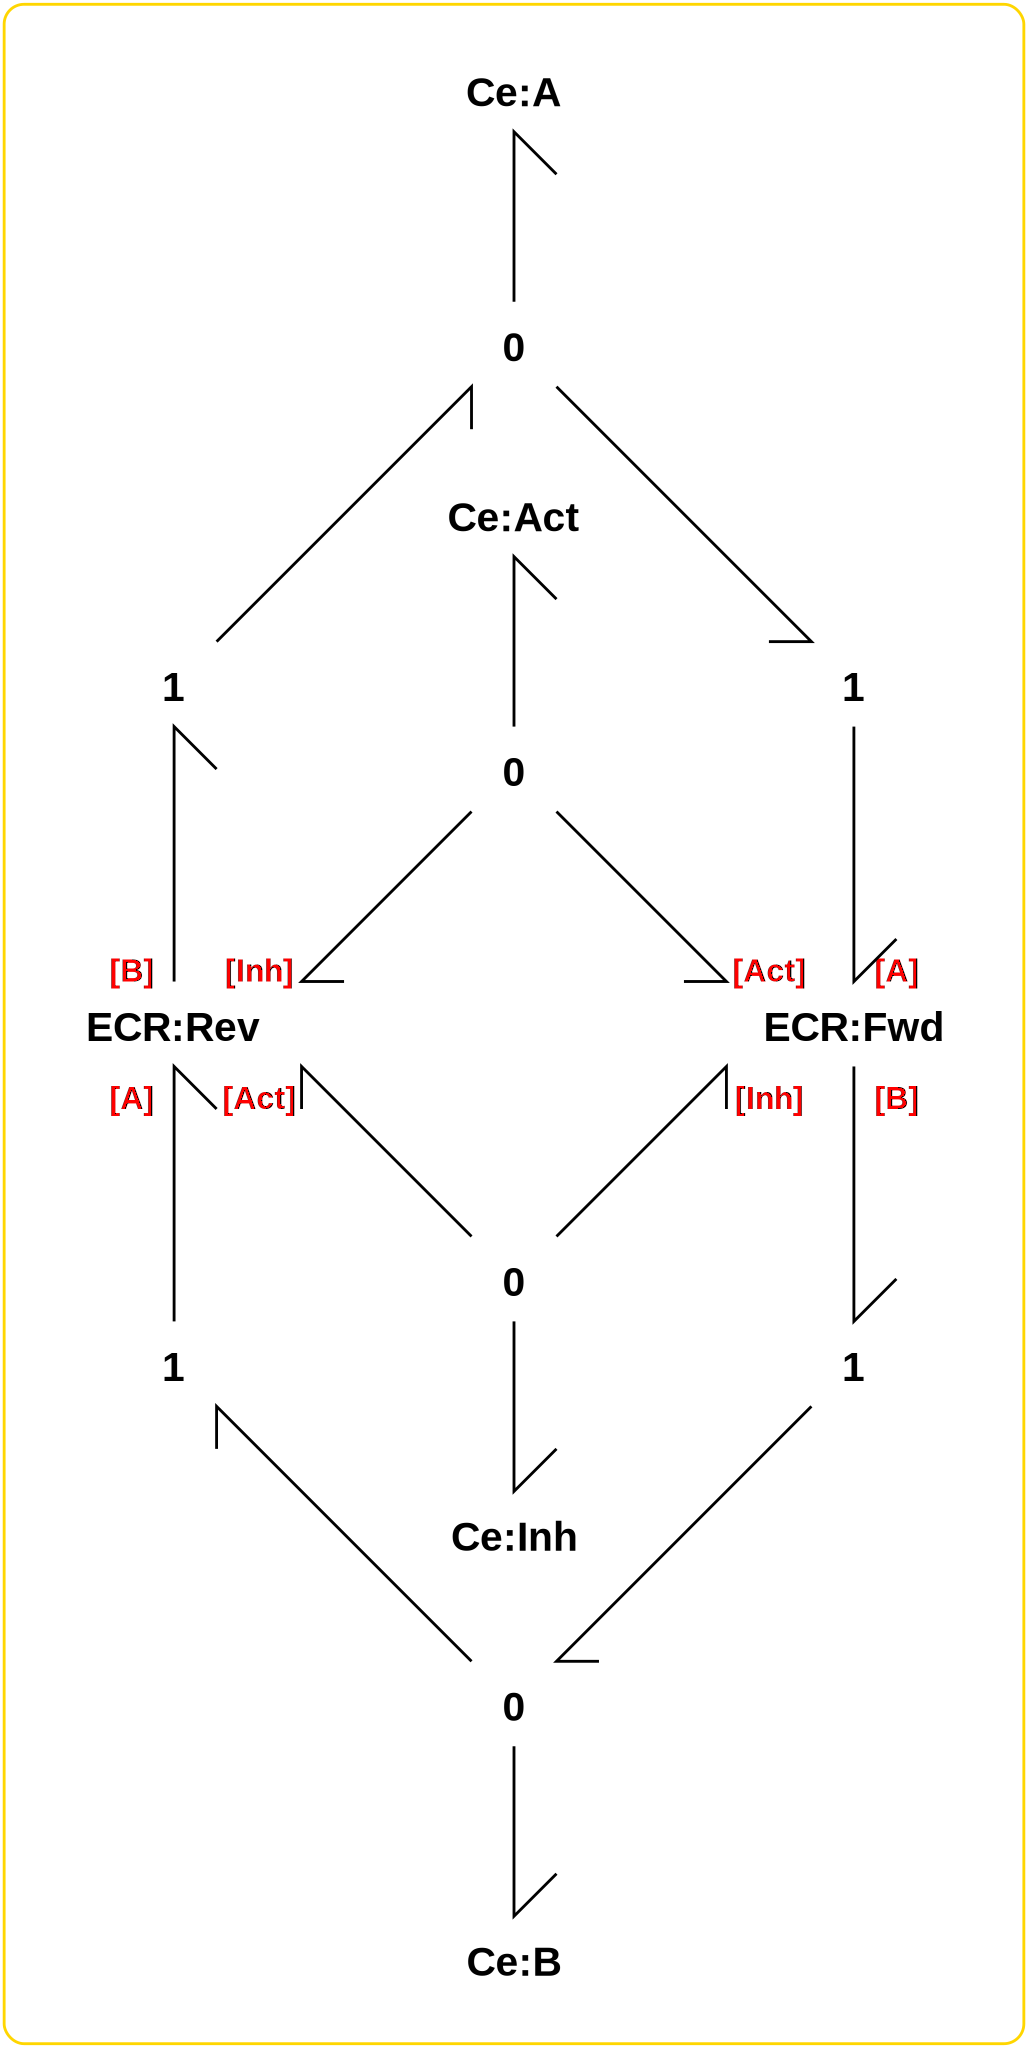

In [8]:
disp.SVG('CFM_abg.svg')

## Steady-state analysis
The net flow out of A in to B is the differtence of the flows in the two ECR components. As activation and inhinition are reversed in the ECR:rev, $N$ is replaced by $-N$.

In [9]:
## Theoretical steady-state flow in Cyclic Flow Modulation
## Based on theoretical steady-state flow in modulated enzyme-catalysed reaction
def CFM_flow(x_A,x_B,x_IA,e0=1,N=4,dphi=True,
             K_A = 1,K_B=1,K_C=1,K_E=1,K_IA=1,
             K_F=1,K_G=0.1,
             kappa_r1 = 1,kappa_r2=1,
             oneway = False,activate=False):
    """Theoretical flows in Cyclic Flow Modulation
    """
    
    v_F,dv_F = mECR_flow(x_A,x_B,x_IA,e0=e0,N=N,dphi=dphi,
                 K_A=K_A,K_B=K_B,K_C=K_C,K_E=K_E,K_IA=K_IA,
                 K_F=K_F,K_G=K_G,
                 kappa_r1 = kappa_r1,kappa_r2=kappa_r2)
    
    v_R,dv_R = mECR_flow(x_B,x_A,x_IA,e0=e0,N=-N,dphi=dphi,
             K_A=K_B,K_B=K_A,K_C=K_C,K_E=K_E,K_IA=1/K_IA,
             K_F=K_F,K_G=K_G,
             kappa_r1=kappa_r1,kappa_r2=kappa_r2)
    
    if oneway:
        v = v_F
        dv = dv_F
    else:
        v = v_F - v_R
        dv = dv_F - dv_R
    
    return v,dv
    

## Stoichiometry and reactions

In [10]:
#s = st.stoich(CFM_abg.model(),quiet=quiet)
s = S['CFM']
print(s['species'])
print(s['reaction'])
chemostats=['A','B','Act','Inh']
chemostats += ['Fwd_ecr_F','Fwd_ecr_G','Rev_ecr_F','Rev_ecr_G']
sc = st.statify(s,chemostats=chemostats)
disp.Latex(st.sprintrl(s,chemformula=True))


['A', 'Act', 'B', 'Inh', 'Fwd_ecr_C', 'Fwd_ecr_E', 'Fwd_ecr_E0', 'Fwd_ecr_F', 'Fwd_ecr_G', 'Rev_ecr_C', 'Rev_ecr_E', 'Rev_ecr_E0', 'Rev_ecr_F', 'Rev_ecr_G']
['Fwd_ecr_r0', 'Fwd_ecr_r1', 'Fwd_ecr_r2', 'Rev_ecr_r0', 'Rev_ecr_r1', 'Rev_ecr_r2']


<IPython.core.display.Latex object>

# Simulation of Steady-state properties

The steady state properties are investigated using dynamic simulation where slowly varing exogenous quantities are used to induce quasi-steady-state behaviour. In each case, the variable is at a constant value to start with followed by a slowly increasing ramp. The response after the initial reponse is plotted to remove artefacts due to the initial transient.


## Set up some parameters for simulation

In [11]:
## Set up some parameters for simulation
def setParameter(oneway=False):
    ## Set up the non-unit parameters and states
    
    parameter = {}
    
    FwdRev = ['Fwd','Rev']
    
    ## Reactions
    I = ['0','1','2']
    for fr in FwdRev:
        for i in I:
            Kappa_i = 'kappa_'+fr+'_ecr_r'+i
            if oneway and (fr is 'Rev'):
                parameter[Kappa_i] = 0
            else:
                parameter[Kappa_i] = kappa
            
    ## Species
    for fr in FwdRev:
        K_i = 'K_'+fr+'_ecr'
        parameter[K_i+'_E'] = K_E
        parameter[K_i+'_F'] = K_F        
        parameter[K_i+'_G'] = K_G
        parameter[K_i+'_C'] = K_C
        
    parameter['K_A'] = K_A
    parameter['K_B'] = K_B 
    parameter['K_Act'] = K_Act
    parameter['K_Inh'] = K_Inh
    
    ## States
    X0 = np.ones(s['n_X'])
    species = s['species']
    E =  ['E0','E','C']
    for fr in FwdRev:
        for e in E:
            ee = fr+'_ecr_'+e
            i = species.index(ee)
            X0[i] = e0/len(E)
    X0[species.index('A')] = x0_A
    
    return parameter,X0

epsilon = 1e-2
K_A = 1
K_B = 1
K_F = 1
K_G = epsilon
K_C = 10
K_E = 1

K_Act = 1
K_Inh = 1

K_IA = K_Inh/K_Act

kappa = 1


e0 = 1
x0_A = 1

parameter,X0 = setParameter()
#print(parameter,X0)

## Simulation code
The flow $v$ is a dynamical function of substrate $x_A$, activation $x_{Act}$, inhibition $x_{Inh}$ and cooperativity index $N$. An approximate steady-state is acjieved by varying one of the three concentrations slowly whilst fixing the other two. The following function does this by declaring the varying function species by the string sX, a fixed species with a number of discrete values as sX1 with values XX1 and the other species as sX2 with value X2.
N can take on a range of values.

deriv=True gives a plot of the derivative of the flow with respect to $\phi$.

In [12]:
def label(sX1,sX2,X1,X2,Loop=False):

    if Loop:
        return f'{sX1}={X1}(Loop flow)'
    else:
        return f'{sX1}={X1}'

def VaryX(sX='A',sX1='Act',sX2='Inh',Xrange=[1e-2,1e2],XX1=[1],X2=1,K_B=1e-6,
          IntPar=False,deriv=False,power=False,oneway=False,
          quiet=True,plotting=True):
    
    spec = s['species']
    reac = s['reaction']

    ## Time
    t_max = int(1e6)
#     N_sim = int(1e4)
    N_sim = int(1e4)
    t = np.linspace(0,t_max,N_sim)
    t_0 = 1e-2*t_max
    t_1 = t_max-t_0
    i_max = len(t)
    i_0 = int(i_max*t_0/t_max)
    i_1 = i_max-i_0
    print(i_0,i_1)
    
    ## Set up the chemostats: vary X
    x_max = Xrange[1]
    x_min = Xrange[0]
    chemo = '{3} + ({0}-{3})*np.heaviside(t-{1},1)*((t-{1})/{2})'.format(x_max,t_0,t_1,x_min)
    X_chemo =  {sX:chemo}
    
    for X1 in XX1:

        ## Non-unit parameters and states
        parameter,X0 = setParameter(oneway=oneway)
        X0[s['spec_index'][sX1]] = X1
        X0[s['spec_index'][sX2]] = X2
        
        ## Simulate
        dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,X_chemo=X_chemo,quiet=quiet)

        ## Extract flows at the chemostatted species
        VV = dat['V']
        dX  = dat['dX']
        dX_A = dX[:,spec.index('A')]
        dX_B = dX[:,spec.index('B')]
        V = dX_B
        
        V_F = VV[:,reac.index('Fwd_ecr_r2')]
        V_R = VV[:,reac.index('Rev_ecr_r2')]
        V_FR = V_F+V_R
        

        ## Extract the state being varied
        X = dat['X'][:,s['spec_index'][sX]]
        
        ## Extract potential being varied
        phi = dat['phi'][:,s['spec_index'][sX]]
        
        ## Extract power
        P_Re = dat['P_Re']
        p_Re = np.sum(P_Re,axis=1) ## Net dissipation
        

        lw = 2
        ls = None
        if deriv:
            slope = np.gradient(V[-i_1:],phi[-i_1:])
            plt.semilogx(X[-i_1:],slope,lw=lw,label=label(sX1,sX2,X1,X2),linestyle=ls)
            ylabel = '$dv/d \log_{10}{x}$'

        elif power:
            #plt.semilogx(X[-i_1:],P_Re[-i_1:],lw=lw)
            plt.semilogx(X[-i_1:],p_Re[-i_1:],lw=lw,label=label(sX1,sX2,X1,X2),linestyle=ls)
            ylabel = '$P_{Re}$'

        else:
            plt.plot(phi[-i_1:],V[-i_1:],lw=lw,label=label(sX1,sX2,X1,X2),linestyle=ls)
            ylabel = '$v$'


                
    plt.xlabel('$\phi_{'+sX+'}$')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    #plt.title('N = '+str(N))
    

    if plotting:
        filename = f'V_{sX}_{sX1}'
        if deriv:
            filename = 'd'+filename
        if power:
            filename = filename+'_P'
        plt.savefig('Figs/'+filename+'.pdf')
        
    plt.show()

    return V[-i_1:],X[-i_1:],phi[-i_1:]


## Vary the substrate concentration.

 The substrate concentration $x_A$ is varied for two values of activation $x_{Act}$.
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
 

100 9900


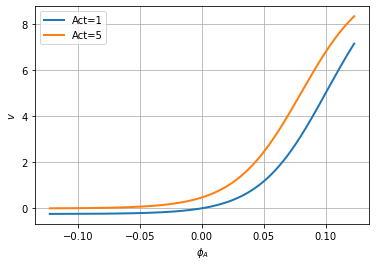

In [13]:
#print(s['species'])
Act = [1,5]
v,x,phi = VaryX(sX='A',sX1='Act',sX2='Inh',XX1=Act,X2=1,oneway=False)
#dat,x = VaryX(sX='A',sX1='Act',sX2='Inh',XX1=Act,X2=1,deriv=True)
#dat,x = VaryX(NN=[N],sX='A',sX1='Act',sX2='Inh',XX1=Act,X2=1,power=True)

### Theory

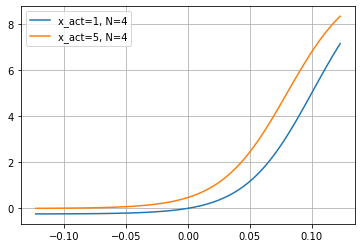

In [14]:
X_A = np.logspace(-2,2,100)
phi_A = st.V_N()*np.log(X_A)
X_B = 1
for act in Act:
    for N in [4]:
        X_IA = 1/act
        v_theory,dv_theory = CFM_flow(X_A,X_B,X_IA,e0=e0,N=N,
                 K_A=K_A,K_B=K_B,K_C=K_C,K_E=K_E,K_IA=K_IA,
                  K_F=K_F,K_G=K_G,                                
                 kappa_r1=kappa,kappa_r2=kappa)
        
        #slope = np.gradient(v_theory,np.log10(X_A))
        plt.plot(phi_A,v_theory,label=f'x_act={act}, N={N}')
    
plt.grid()
plt.legend()
plt.show()

## Vary the activation species concentration.

 The activation species concentration $x_{Act}$ is varied for three values of $x_{Inh}$. 
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
 

100 9900


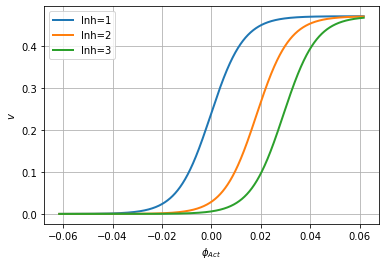

100 9900


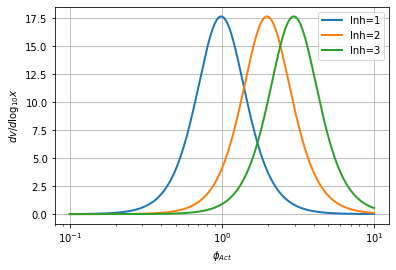

100 9900


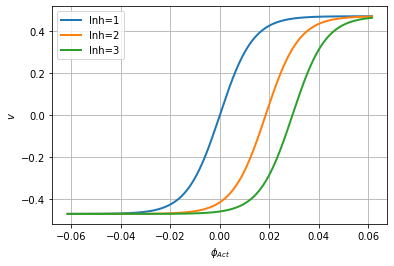

100 9900


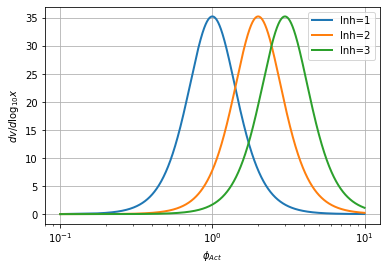

In [15]:
Inh = [1,2,3]
for oneway in [True,False]:
    for deriv in [False,True]:
        v,x,phi = VaryX(sX='Act',sX1='Inh',sX2='A',XX1=Inh,X2=1,oneway=oneway,Xrange=[0.1,10],deriv=deriv)


### Theory

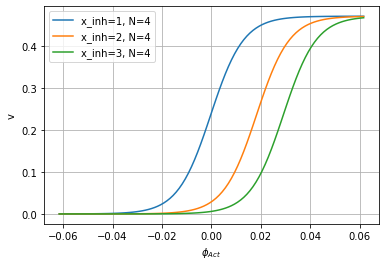

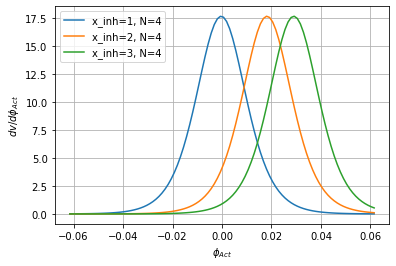

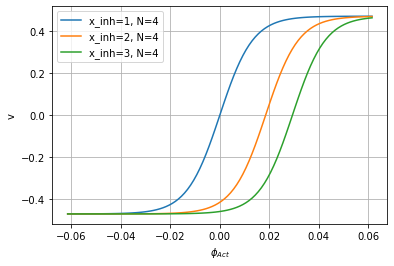

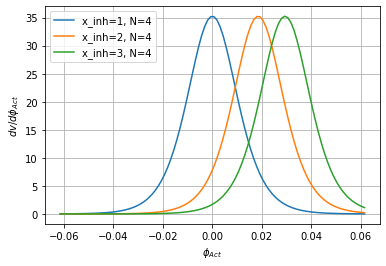

In [16]:
X_Act = np.logspace(-1,1,100)
phi_Act = st.V_N()*np.log(X_Act)

X_A = 1
X_B = 1


for oneway in [True,False]:
    for deriv in [False,True]:
        for inh in Inh:
            for N in [4]:
                X_IA = X_Act/inh
                v_theory,dv_theory = CFM_flow(X_A,X_B,X_IA,e0=e0,N=-N,
                         K_A=K_A,K_B=K_B,K_C=K_C,K_E=1,K_IA=1,
                          K_F=K_F,K_G=K_G,                                
                         kappa_r1 = 1,kappa_r2=1, oneway=oneway)

                if deriv:
                    slope = np.gradient(v_theory,phi_Act)
                    plt.plot(phi_Act,dv_theory,label=f'x_inh={inh}, N={N}')
                    #plt.plot(phi_Act,dv_theory*X_IA/st.V_N(),label=f'x_inh={inh}',ls='dashed')
                else:
                    plt.plot(phi_Act,v_theory,label=f'x_inh={inh}, N={N}')
        if deriv:
            ylabel = '$dv/d\phi_{Act}$'
        else:
            ylabel = 'v'
        plt.ylabel(ylabel)
        plt.xlabel('$\phi_{Act}$')
        plt.grid()
        plt.legend()
        plt.show()
    


## Vary the inhibition species concentration.

 The activation species concentration $x_{Inh}$ is varied for three values of $x_{Act}$. 
 
 - dotted lines give the cyclic flow.
 - The derivative is also plotted.
 

100 9900


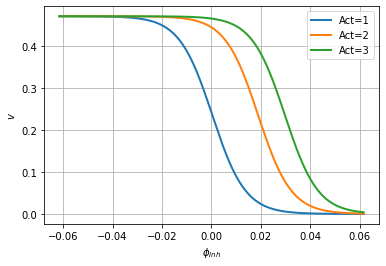

100 9900


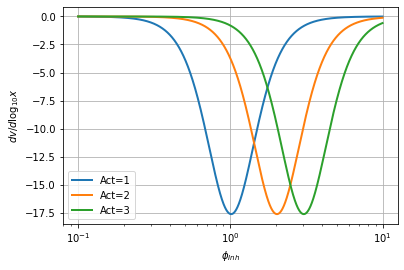

100 9900


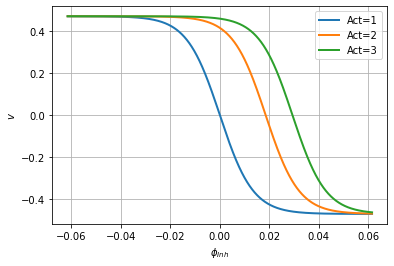

100 9900


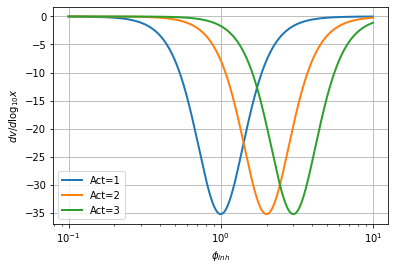

In [17]:
Act = [1,2,3]
for oneway in [True,False]:
    for deriv in [False,True]:
        v,x,phi = VaryX(sX='Inh',sX1='Act',sX2='A',XX1=Inh,X2=1,oneway=oneway,Xrange=[0.1,10],deriv=deriv)
#dat,x = VaryX(NN=[N],sX='Act',sX1='Inh',sX2='A',XX1=Inh,X2=1,deriv=True)
#dat,x = VaryX(NN=[N],sX='Act',sX1='Inh',sX2='A',XX1=Inh,X2=1,power=True)

### Theory

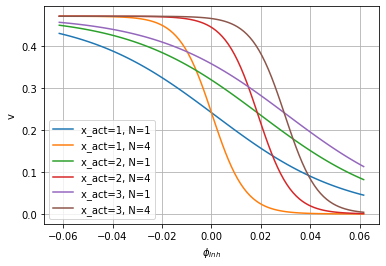

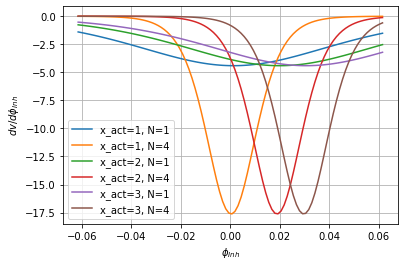

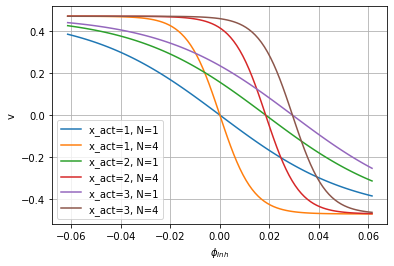

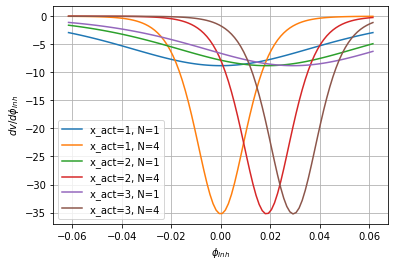

In [18]:
X_Inh = np.logspace(-1,1,100)
phi_Inh = st.V_N()*np.log(X_Inh)

X_A = 1
X_B = 1

for oneway in [True,False]:
    for deriv in [False,True]:
        for act in Act:
            for N in [1,4]:
#                if N is 4:
#                     v,x,phi = VaryX(sX='Inh',sX1='Act',sX2='A',XX1=Inh,X2=1,oneway=oneway,Xrange=[0.1,10],deriv=deriv)
#                     if not deriv:
#                         plt.plot(phi,v,ls='dashed',color = 'black')

                X_IA = X_Inh/act
                v_theory,dv_theory = CFM_flow(X_A,X_B,X_IA,e0=e0,N=N,
                         K_A=K_A,K_B=K_B,K_C=K_C,K_E=1,K_IA=1,
                         K_F=K_F,K_G=K_G,                                 
                         kappa_r1 = 1,kappa_r2=1,oneway = oneway)

                if deriv:
                    #slope = np.gradient(v_theory,phi_Inh)
                    plt.plot(phi_Inh,dv_theory,label=f'x_act={act}, N={N}')
                    #plt.plot(phi_Inh,dv_theory*X_IA/st.V_N(),ls='dashed')
                else:
                    plt.plot(phi_Inh,v_theory,label=f'x_act={act}, N={N}')

        if deriv:
            ylabel = '$dv/d\phi_{Inh}$'
        else:
            ylabel = 'v'
        plt.ylabel(ylabel) 
        plt.xlabel('$\phi_{Inh}$')
        plt.grid()
        plt.legend()
        plt.show()




### Compare simulation and theory (sanity check)

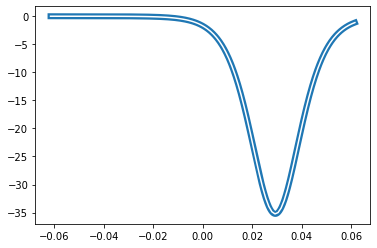

In [19]:
## Compare simulation and theory for last plot
dv = np.gradient(v,phi)
plt.plot(phi,dv,linewidth=6)
plt.plot(phi_Inh,dv_theory,color='white')


## Discussion

- Both positive and negative flow rates are possible
- The substrate concentration affects net flow but not loop flow.
- Loop flow is affected by the degree of activation/inhibition as well as the driving species AAf, BBf, AAr and BBr.
- Increasing activation increases flow - this corresponds to positive feedback with positive incremental gain given by the derivative plots.
- Increasing inhibition decreases flow - this corresponds to negative feedback with negative incremental gain given by the derivative plots.
- the behaviour is dependent on the parameters of the particular enzyme-catalysed reaction; those used here are for illustration.



# Fructose-2,6-phosphate (\ch{F26P}) 
The reaction 
\ch{F6P + ATP <>[PFK2] F26P + ADP}
is catalysed by the enzyme PFK2 where

- \ch{PFK2} phosphofructokinase-2
- \ch{F6P} fructose-6-phosphate
- \ch{F26P} fructose-2,6-biphosphate

As pointed out by 
<cite data-cite="GarGri17">Garret and Grisham (2017)</cite> section 22.2a,
the PFK2-catalysed reaction forms a cycle with the reaction:
\ch{F26P + H2O <>[F26BP] F6P + Pi}
where:

- \ch{F26BP} fructose-2,6-biphosphatase
- \ch{Pi} inorganic phosphate

The species which activate PFK2 and inhibit F26BP include:

- \ch{AMP}
- \ch{F6P} fructose-6-phosphate

Thus this pair of reactions is a further example of Cyclic Flow Modulation (CFM).

Moreover, the PFK and PFK2 CFMs stongly interact:

- The PFK CFM is positively modulated by the product of the PFK2 CFM: \ch{F26P} 
- the PFK2 CFM is positively modulated by the substrate of the PKF (and PFK2) CFM: \ch{F6P}
- both are positively modulated by \ch{AMP}.
- this has been sugested as a mechanism for **integral action** <cite data-cite="CloWel10">Cloutier and Wellstead (2010)</cite>.

TIGAR (TP53-induced gycolysis and apoptosis regulator) mimics \ch{F26P}; this is related to oncogenesis
<cite data-cite="GarGri17">Garret and Grisham (2017).

## Fructose-2,6-phosphate (\ch{F26P}) CFM as an integrator
<cite data-cite="CloWel10">Cloutier and Wellstead (2010)</cite> suggest that the reaction catalysed by PFK2 generating \ch{F26P} can be used as an integrator based on the fact that \ch{F26P} is a strong activator of PFK.
Their model involves a single irreversible reaction \ch{F6P + ATP ->[PFK2] F26P + ADP}; the basic idea is that the 
the concentration \ch{F26P} is the integral of the molar flow which is modulated by \ch{AMP}.

Within the CFM context, a similar effect can be acheived by *not* setting species \ch{B} to be a chemostat and its state will indeed be the integral of the net CFM flow. However, unlike a true integrator, this flow will depend on the amount of B $x_B$ and thus the CFM in these circumstances will only approximate an integrator. This appproximation will depend on the parameters of the CFM itself.

The approximation will look like a high-gain low-pass filter rather than an integrator.

An alternative approach would have both species \ch{A} and \ch{B} not chemostats; they would them form a conserved moiety and the response would be *symmetrical*. Are there any actual biomolecular systems like this?

Both the *asymmetric* and *symmetric* cases are simulated below.

## Simulation
The following simulation illustrates the basic properties of Both the *asymmetric* and *symmetric* cases for a particular set of parameter. The key changes are:

- Asymmetric
    - **Ce:B** is no longer a chemostat
- Symmetric
    - Neither **Ce:A** or **Ce:B** are chemostats
    - The initial state of x_A=999 - the total conserved moiety is thus 1000

The simulation starts from the steady-state and 
\begin{align}
x_{Act} &= 
\begin{cases}
5 & \text{for $10 < t < 200$}\\
1 & \text{otherwise}
\end{cases}\\
x_{Inh} &= 
\begin{cases}
5 & \text{for $200 < t < 400$}\\
1 & \text{otherwise}
\end{cases}
\end{align}



{'Act': '(1+4*(np.heaviside(t-10,1) - np.heaviside(t-200,1)))', 'Inh': '(1+4*(np.heaviside(t-200,1) - np.heaviside(t-600,1)))'}


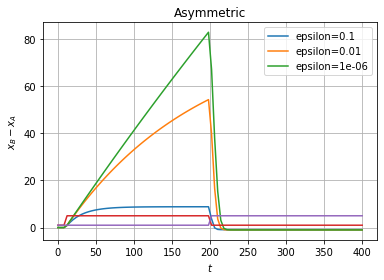

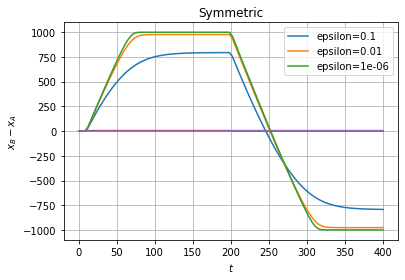

In [20]:
t_ss = np.linspace(0,10000)
t = np.linspace(0,400,100)

## Indices of species
for i,spec in enumerate(s['species']):
    exec(f'i_{spec} = {i}')
    
# Activation and inhition
amp_Act = 4
amp_Inh = 4
t0 = 10
t1 = 200
t2 = 200
t3 = 600
Act_chemo = f'(1+{amp_Act}*(np.heaviside(t-{t0},1) - np.heaviside(t-{t2},1)))'
Inh_chemo = f'(1+{amp_Inh}*(np.heaviside(t-{t1},1) - np.heaviside(t-{t3},1)))'
X_chemo =  {'Act':Act_chemo, 'Inh':Inh_chemo}
#X_chemo = {'Act':'1+1'}
print(X_chemo)
#N=2
e0 = 1

for double in [False,True]:

    if double:
        chemostats=['Act','Inh']
        x0_A = 999
        title = 'Symmetric'
    else:
        chemostats=['A','Act','Inh']
        x0_A = 1
        title = 'Asymmetric'

    chemostats += ['Fwd_ecr_F','Fwd_ecr_G','Rev_ecr_F','Rev_ecr_G']
    scB = st.statify(s,chemostats=chemostats)
    #X_chemo=None


    Epsilon = [1e-1,1e-2,1e-6]
    for epsilon in Epsilon:

        K_G = epsilon
        parameter,X0 = setParameter(oneway=False)
    #     parameter['K_Rev_ecr_F'] = epsilon
    #     parameter['K_Rev_ecr_G'] = epsilon**2

        ## Get the steady-state
        dat = st.sim(s,sc=scB,t=t_ss,parameter=parameter,X0=X0,X_chemo=None,quiet=quiet)
        X_ss = dat['X'][-1]


        ## Simulate from steady-state
        dat = st.sim(s,sc=scB,t=t,parameter=parameter,X0=X_ss,X_chemo=X_chemo,quiet=quiet)
        X = dat['X']
        x_A = X[:,i_A]
        x_B = X[:,i_B]
        x_Act = X[:,i_Act]
        x_Inh = X[:,i_Inh]
        plt.plot(t,x_B-x_A,label=f'epsilon={epsilon}')

    plt.plot(t,x_Act)
    plt.plot(t,x_Inh)
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('$t$')
    plt.ylabel('$x_B-x_A$')
    plt.show()

## Discussion: asymmetric case

- In the context of the fructose-2,6-phosphate (\ch{F26P}) CFM, the activator Act is AMP and the product B is \ch{F26P}
- The step change in AMP activation at time t=10 gives rise to an increasing value of \ch{F26P}: this is similar to an integrator response.
- When the activation ceases, the amount of  \ch{F26P} decays.
- As  \ch{F26P}  is an activator of PFK, the behaviour would give rise to a similar increase and then decrease of the flow through the PFK reaction.
- Thus PFK + PFK-2 act as a proportional + integral (PI) controller in the context of regulating energy levels (as measured by AMP) via metabolism.

## Discussion: symmetric case

- This setup is speculative at the moment
- \ch{B} would be used to activate, and \ch{A} to inhibit, another CFM cycle.
- note that \ch{F6P} is the common precurser for both the \ch{F16P} and \ch{F26P} reactions.